In [137]:
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import pickle

In [138]:
from torch.utils.data import Dataset
import torch
class NetworkLogDataset(Dataset):
    def __init__(self, X_cat, X_num, y):
        self.X_cat = torch.tensor(X_cat, dtype=torch.long)
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]


In [139]:
import torch.nn as nn
import torch
import torch.nn.functional as F


class TabTransformer(nn.Module):


    def __init__(self,categorical_cardinalities,num_numerical, emb_dim=16, num_heads=2, ff_hidden=64):
        super(TabTransformer,self).__init__()

        # Embedding Layers

        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality,emb_dim) for cardinality in categorical_cardinalities
        ])

        self.num_categoricals =  len(categorical_cardinalities)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim,nhead=num_heads,batch_first=True)
        self.transformer=nn.TransformerEncoder(encoder_layer,num_layers=1)
        
        # LayerNorm for numerical features
        self.norm_num = nn.LayerNorm(num_numerical)

        # MLP classifier
        self.fc = nn.Sequential(
            nn.Linear(emb_dim*self.num_categoricals+num_numerical,ff_hidden),
            nn.ReLU(),
            nn.Dropout(.3),
            nn.Linear(ff_hidden,1),
            nn.Sigmoid()
        )

    
    def forward(self,x_cat,x_num):
        embeds= [emb(x_cat[:,i])for i,emb in enumerate(self.embeddings)]
        x_cat_emb=torch.stack(embeds,dim=1)

        x_transformed=self.transformer(x_cat_emb)
        x_flat=x_transformed.flatten(1)
        x_num_norm=self.norm_num(x_num)
        x_full = torch.cat([x_flat,x_num_norm],dim=1)

        return self.fc(x_full)



In [140]:
x_train=pd.read_csv("../../../data/starter/train_val_data/x_train.csv").drop(columns=['Unnamed: 0'])
x_val=pd.read_csv("../../../data/starter/train_val_data/x_val.csv").drop(columns=['Unnamed: 0'])
y_train=pd.read_csv("../../../data/starter/train_val_data/y_train.csv").drop(columns=['Unnamed: 0'])
y_val=pd.read_csv("../../../data/starter/train_val_data/y_val.csv").drop(columns=['Unnamed: 0'])


In [141]:
with open("../../../resources/data_preprocessing/label_encoders.pkl","rb") as f:
    labels_encoder=pickle.load(f)
num_col = [col for col in x_train.columns if col not in labels_encoder.keys()]


In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Cardinalities for embedding layers
categorical_cardinates = [len(label_encoder.classes_) for label_encoder in labels_encoder.values()]

# Dataset & DataLoader
dataset_train = NetworkLogDataset(
    x_train[list(labels_encoder.keys())].values,
    x_train[num_col].values,
    y_train.values
)
dataset_val = NetworkLogDataset(
    x_val[list(labels_encoder.keys())].values,
    x_val[num_col].values,
    y_val.values
)

train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=64)

# Initialize model
model = TabTransformer(
    categorical_cardinates,
    num_numerical=x_train[num_col].shape[1]
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
losses_train=[]
losses_val=[]
accuracy_val=[]
accuracy_train=[]
correct_train = 0
total_train = 0
# Training loop
for epoch in range(10):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for x_cat, x_num, y_batch in loop:
        x_cat = x_cat.to(device)
        x_num = x_num.to(device)
        y_batch = y_batch.to(device).float().squeeze()

        preds = model(x_cat, x_num).squeeze()
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_cat_val, x_num_val, y_val in val_loader:
            x_cat_val = x_cat_val.to(device)
            x_num_val = x_num_val.to(device)
            y_val = y_val.to(device).float().squeeze()

            val_preds = model(x_cat_val, x_num_val).squeeze()
            v_loss = criterion(val_preds, y_val)
            val_loss += v_loss.item()

            predicted = (val_preds > 0.5).float()
            correct += (predicted == y_val).sum().item()
            total += y_val.size(0)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"Val Acc: {correct/total:.4f}")
    losses_train=losses_train+[train_loss/len(train_loader)]
    losses_val=losses_val+[val_loss/len(val_loader)]
    accuracy_val=accuracy_val+[correct/total]
    accuracy_train=accuracy_train+[correct_train/total_train]


Using device: cpu


Epoch 1 | Train Loss: 0.0393 | Val Loss: 0.0001 | Val Acc: 1.0000


KeyboardInterrupt: 

In [127]:
torch.save(model.state_dict(), "../../../resources/model/tab_transformer_model.pkl")

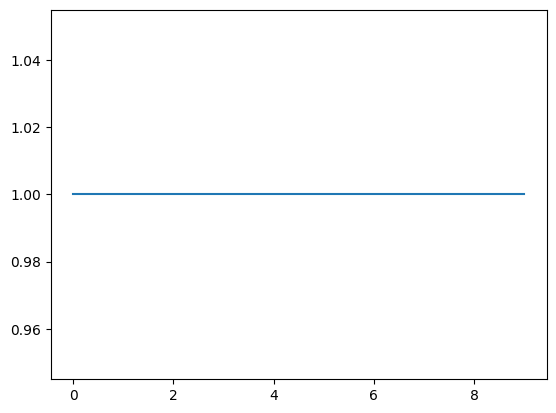

In [135]:
plt.plot(accuracy_val)